<img src="https://drive.google.com/uc?export=view&id=1Y1Fsikt1iifgJAuyri-TGLfa_Xyd-R31"  width="800" height="300">


# <center> **Detección de Fake News** </center>

Integrantes:

-Kevin Andres Florez Diaz - 2201494

Columna objetivo: "label"

Valores de label:

      0 (Fake)
      1 (Real)


####**Librerias y Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

ruta = '/content/drive/MyDrive/IA/WELFake_Dataset.csv'
df = pd.read_csv(ruta)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

####**Shape, columns y head**

In [4]:
print("Shape del dataset:", df.shape)
print("\nColumnas del dataset:")
print(df.columns.tolist())
print("\nPrimeras 5 filas:")
df.head()

Shape del dataset: (72134, 4)

Columnas del dataset:
['Unnamed: 0', 'title', 'text', 'label']

Primeras 5 filas:


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


####**Describe**

In [5]:
print("Descripción general:")
print(df.describe())

print("\nDescripción de columnas de texto:")
print(df.describe(include=['object']))

print("\nInformación adicional:")
print(f"Número total de registros: {len(df)}")
print(f"Número de columnas: {len(df.columns)}")

Descripción general:
         Unnamed: 0         label
count  72134.000000  72134.000000
mean   36066.500000      0.514404
std    20823.436496      0.499796
min        0.000000      0.000000
25%    18033.250000      0.000000
50%    36066.500000      1.000000
75%    54099.750000      1.000000
max    72133.000000      1.000000

Descripción de columnas de texto:
                                                    title   text
count                                               71576  72095
unique                                              62347  62718
top     Factbox: Trump fills top jobs for his administ...       
freq                                                   14    738

Información adicional:
Número total de registros: 72134
Número de columnas: 4


In [6]:
print("\nDistribución de etiquetas:")
print(df['label'].value_counts())
print("\nPorcentaje de cada clase:")
print(df['label'].value_counts(normalize=True) * 100)


Distribución de etiquetas:
label
1    37106
0    35028
Name: count, dtype: int64

Porcentaje de cada clase:
label
1    51.440375
0    48.559625
Name: proportion, dtype: float64


####**Limpieza**

In [7]:

print("Valores nulos por columna:")
print(df.isnull().sum())

print(f"\nFilas duplicadas: {df.duplicated().sum()}")

# Verificar textos únicos en cada columna de texto
print("\nAnálisis de unicidad en columnas de texto:")
for col in ['title', 'text']:
    if col in df.columns:
        unique_count = df[col].nunique()
        total_count = len(df)
        print(f"{col}: {unique_count} valores únicos de {total_count} total")
        print(f"Porcentaje de unicidad: {(unique_count/total_count)*100:.2f}%")

Valores nulos por columna:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

Filas duplicadas: 0

Análisis de unicidad en columnas de texto:
title: 62347 valores únicos de 72134 total
Porcentaje de unicidad: 86.43%
text: 62718 valores únicos de 72134 total
Porcentaje de unicidad: 86.95%


In [8]:

df_original_shape = df.shape

# Eliminar filas con NaN en columnas importantes
df_clean = df.dropna(subset=['title', 'text', 'label'])

# Eliminar duplicados basados en contenido
df_clean = df_clean.drop_duplicates(subset=['title', 'text'])

# Eliminar columna ID
if 'Unnamed: 0' in df_clean.columns:
    df_clean = df_clean.drop('Unnamed: 0', axis=1)

print(f"\nShape original: {df_original_shape}")
print(f"Shape después de limpieza: {df_clean.shape}")
print(f"Filas eliminadas: {df_original_shape[0] - df_clean.shape[0]}")

df = df_clean.copy()


Shape original: (72134, 4)
Shape después de limpieza: (63121, 3)
Filas eliminadas: 9013


####**Graficos**

/tmp/ipython-input-2698069607.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Fake', 'Real'])


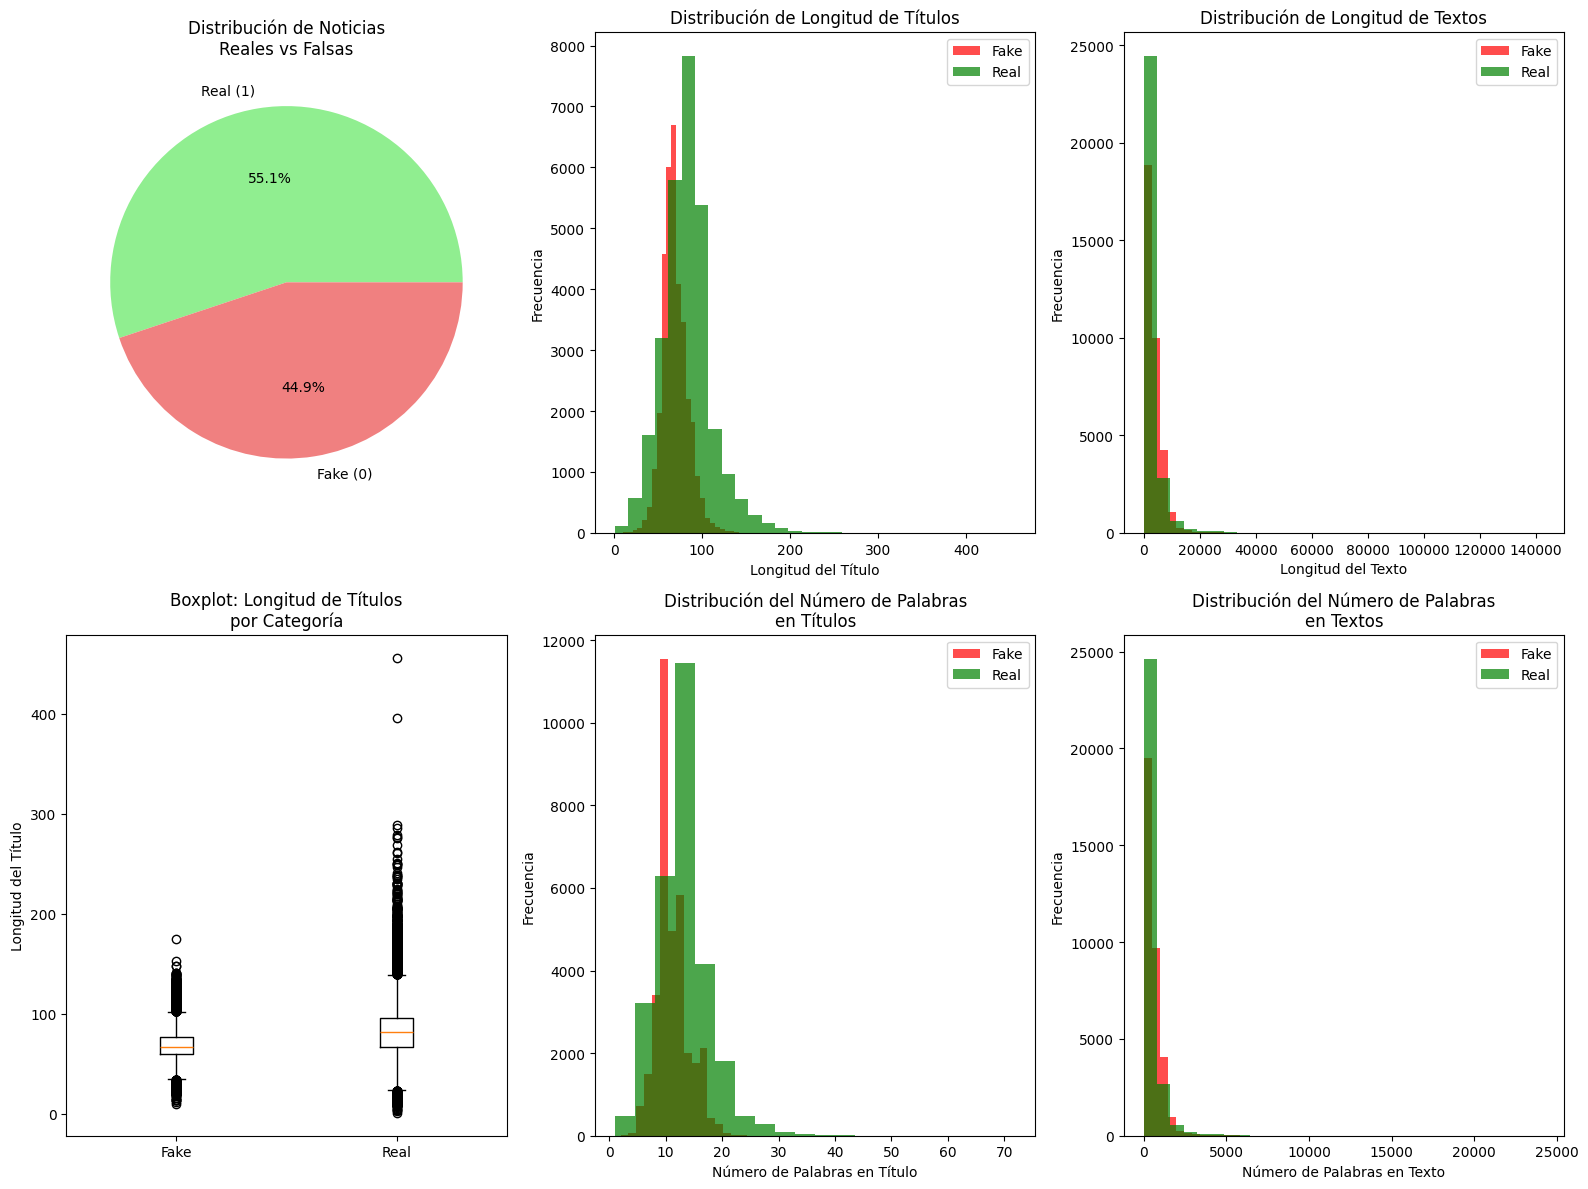

In [9]:
fig = plt.figure(figsize=(16, 12))

# Gráfico 1: Real vs Fake
plt.subplot(2, 3, 1)
labels_counts = df['label'].value_counts()
plt.pie(labels_counts.values, labels=['Real (1)', 'Fake (0)'], autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'])
plt.title('Distribución de Noticias\nReales vs Falsas')

# Gráfico 2: Longitud de títulos por categoría
plt.subplot(2, 3, 2)
df['title_length'] = df['title'].str.len()
plt.hist(df[df['label']==0]['title_length'], alpha=0.7, label='Fake', color='red', bins=30)
plt.hist(df[df['label']==1]['title_length'], alpha=0.7, label='Real', color='green', bins=30)
plt.xlabel('Longitud del Título')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitud de Títulos')
plt.legend()

# Gráfico 3: Longitud de texto por categoría
plt.subplot(2, 3, 3)
df['text_length'] = df['text'].str.len()
plt.hist(df[df['label']==0]['text_length'], alpha=0.7, label='Fake', color='red', bins=30)
plt.hist(df[df['label']==1]['text_length'], alpha=0.7, label='Real', color='green', bins=30)
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitud de Textos')
plt.legend()

# Gráfico 4: Estadísticas de longitud
plt.subplot(2, 3, 4)
data_to_plot = [df[df['label']==0]['title_length'], df[df['label']==1]['title_length']]
plt.boxplot(data_to_plot, labels=['Fake', 'Real'])
plt.ylabel('Longitud del Título')
plt.title('Boxplot: Longitud de Títulos\npor Categoría')

# Gráfico 5: Número de palabras en títulos
plt.subplot(2, 3, 5)
df['title_word_count'] = df['title'].str.split().str.len()
plt.hist(df[df['label']==0]['title_word_count'], alpha=0.7, label='Fake', color='red', bins=20)
plt.hist(df[df['label']==1]['title_word_count'], alpha=0.7, label='Real', color='green', bins=20)
plt.xlabel('Número de Palabras en Título')
plt.ylabel('Frecuencia')
plt.title('Distribución del Número de Palabras\nen Títulos')
plt.legend()

# Gráfico 6: Número de palabras en texto
plt.subplot(2, 3, 6)
df['text_word_count'] = df['text'].str.split().str.len()
plt.hist(df[df['label']==0]['text_word_count'], alpha=0.7, label='Fake', color='red', bins=30)
plt.hist(df[df['label']==1]['text_word_count'], alpha=0.7, label='Real', color='green', bins=30)
plt.xlabel('Número de Palabras en Texto')
plt.ylabel('Frecuencia')
plt.title('Distribución del Número de Palabras\nen Textos')
plt.legend()

plt.tight_layout()
plt.show()

####**Tomar un sample del dataset**

In [10]:
print("\n Reduciendo tamaño del dataset para mayor velocidad")
df_sample = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=5000, random_state=42))
print(f"Dataset reducido de {len(df)} a {len(df_sample)} muestras")


 Reduciendo tamaño del dataset para mayor velocidad
Dataset reducido de 63121 a 10000 muestras


/tmp/ipython-input-3624979144.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=5000, random_state=42))


####**Convertir texto a numeros**

In [11]:
df_sample['combined_text'] = df_sample['title'] + " " + df_sample['text']

# Vectorizar texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=1000,
                             stop_words='english',
                             max_df=0.8,
                             min_df=5)
X = vectorizer.fit_transform(df_sample['combined_text'])
y = df_sample['label'].values

print(f"Shape de X después de vectorización: {X.shape}")
print(f"Tipo de datos: {type(X)}")

Shape de X después de vectorización: (10000, 1000)
Tipo de datos: <class 'scipy.sparse._csr.csr_matrix'>


####**Particionado 80/20**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño de entrenamiento: {X_train.shape[0]} ({(X_train.shape[0]/X.shape[0])*100:.1f}%)")
print(f"Tamaño de prueba: {X_test.shape[0]} ({(X_test.shape[0]/X.shape[0])*100:.1f}%)")
print(f"\nDistribución en entrenamiento:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Clase {label}: {count} ({(count/len(y_train))*100:.1f}%)")

Tamaño de entrenamiento: 8000 (80.0%)
Tamaño de prueba: 2000 (20.0%)

Distribución en entrenamiento:
  Clase 0: 4000 (50.0%)
  Clase 1: 4000 (50.0%)


####**Modelos base (Sin parametros)**

####**Decision Tree**

In [13]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred, target_names=['Fake', 'Real']))

Decision Tree Accuracy: 0.8920

Classification Report:
              precision    recall  f1-score   support

        Fake       0.89      0.89      0.89      1000
        Real       0.89      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



####**Random Forest**

In [14]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Fake', 'Real']))

Random Forest Accuracy: 0.9235

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.91      0.92      1000
        Real       0.91      0.94      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



####**SVC**

In [15]:
svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_pred)

print(f"SVC Accuracy: {svc_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svc_pred, target_names=['Fake', 'Real']))

SVC Accuracy: 0.9285

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.92      0.93      1000
        Real       0.92      0.94      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



####**Learning Curves**

####**Decision Tree - max_depth**

  max_depth=5: Train=0.9125, Test=0.9025
  max_depth=10: Train=0.9583, Test=0.9055
  max_depth=15: Train=0.9815, Test=0.9050
  max_depth=20: Train=0.9885, Test=0.9000
  max_depth=25: Train=0.9912, Test=0.8980
  max_depth=30: Train=0.9929, Test=0.9015
  max_depth=35: Train=0.9935, Test=0.8990
  max_depth=40: Train=0.9941, Test=0.8980
  max_depth=45: Train=0.9946, Test=0.8985
  max_depth=50: Train=0.9966, Test=0.8930
✓ Gráfica guardada como 'dt_learning_curve.png'


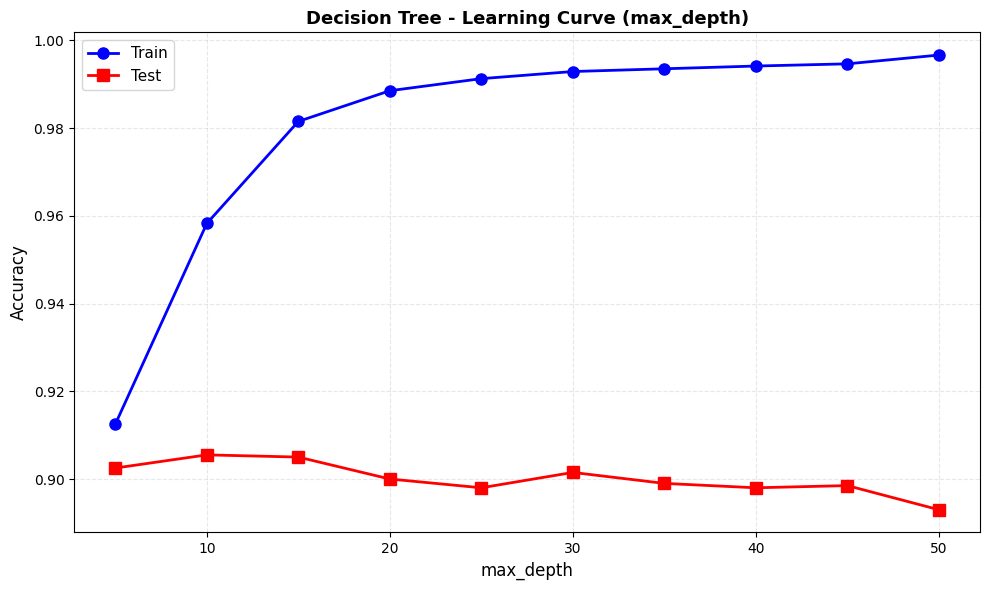

In [16]:
max_depths = range(5, 51, 5)
dt_train_scores = []
dt_test_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_score = accuracy_score(y_train, dt.predict(X_train))
    test_score = accuracy_score(y_test, dt.predict(X_test))
    dt_train_scores.append(train_score)
    dt_test_scores.append(test_score)
    print(f"  max_depth={depth}: Train={train_score:.4f}, Test={test_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(max_depths, dt_train_scores, 'o-', color='blue', label='Train', linewidth=2, markersize=8)
plt.plot(max_depths, dt_test_scores, 's-', color='red', label='Test', linewidth=2, markersize=8)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree - Learning Curve (max_depth)', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('dt_learning_curve.png', dpi=300, bbox_inches='tight')
print("✓ Gráfica guardada como 'dt_learning_curve.png'")
plt.show()

####**Random Forest - n_estimators**

  n_estimators=20: Train=0.9995, Test=0.9105
  n_estimators=40: Train=0.9999, Test=0.9180
  n_estimators=60: Train=0.9999, Test=0.9220
  n_estimators=80: Train=0.9999, Test=0.9235
  n_estimators=100: Train=0.9999, Test=0.9235
  n_estimators=120: Train=0.9999, Test=0.9260
  n_estimators=140: Train=0.9999, Test=0.9235
  n_estimators=160: Train=0.9999, Test=0.9245
  n_estimators=180: Train=0.9999, Test=0.9270
  n_estimators=200: Train=0.9999, Test=0.9270


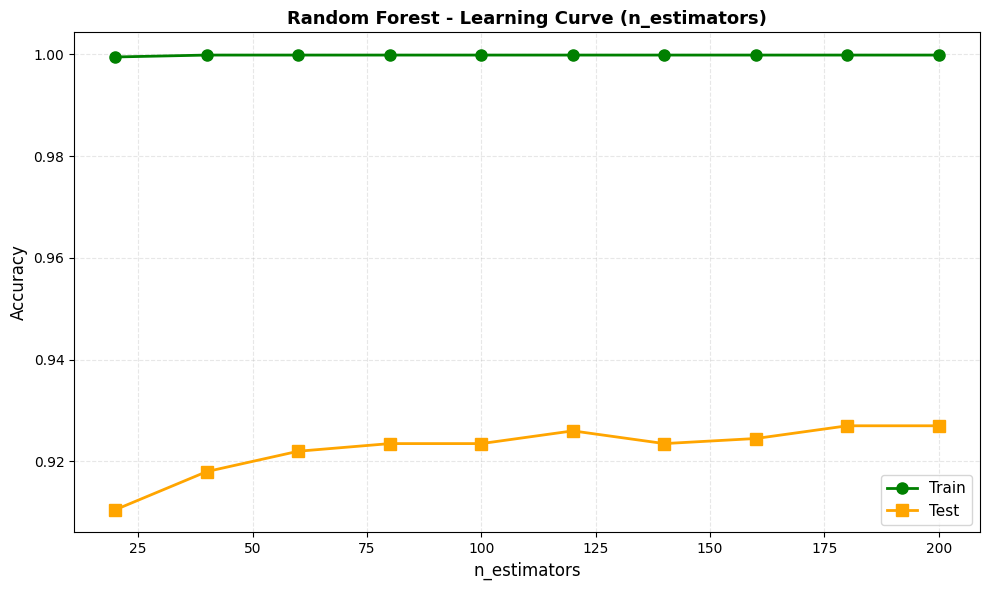

In [17]:
n_estimators_range = range(20, 201, 20)
rf_train_scores = []
rf_test_scores = []

for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=42)
    rf.fit(X_train, y_train)
    train_score = accuracy_score(y_train, rf.predict(X_train))
    test_score = accuracy_score(y_test, rf.predict(X_test))
    rf_train_scores.append(train_score)
    rf_test_scores.append(test_score)
    print(f"  n_estimators={n_est}: Train={train_score:.4f}, Test={test_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rf_train_scores, 'o-', color='green', label='Train', linewidth=2, markersize=8)
plt.plot(n_estimators_range, rf_test_scores, 's-', color='orange', label='Test', linewidth=2, markersize=8)
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Random Forest - Learning Curve (n_estimators)', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('rf_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

####**SVC - Kernel**

  Probando kernel=linear...
    Train=0.9466, Test=0.9240
  Probando kernel=poly...
    Train=0.9990, Test=0.8995
  Probando kernel=rbf...
    Train=0.9852, Test=0.9285


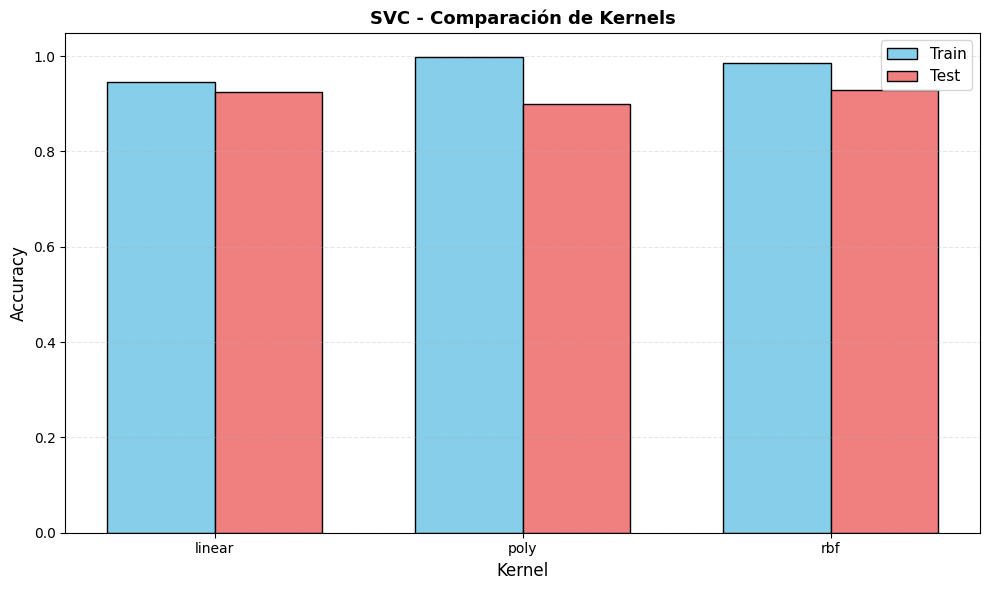

In [18]:
kernels = ['linear', 'poly', 'rbf']
svc_scores = {'train': [], 'test': []}

for kernel in kernels:
    print(f"  Probando kernel={kernel}...")
    svc = SVC(kernel=kernel, random_state=42)
    svc.fit(X_train, y_train)
    train_score = accuracy_score(y_train, svc.predict(X_train))
    test_score = accuracy_score(y_test, svc.predict(X_test))
    svc_scores['train'].append(train_score)
    svc_scores['test'].append(test_score)
    print(f"    Train={train_score:.4f}, Test={test_score:.4f}")

plt.figure(figsize=(10, 6))
x_pos = np.arange(len(kernels))
width = 0.35
plt.bar(x_pos - width/2, svc_scores['train'], width,
            label='Train', color='skyblue', edgecolor='black')
plt.bar(x_pos + width/2, svc_scores['test'], width,
            label='Test', color='lightcoral', edgecolor='black')
plt.xlabel('Kernel', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('SVC - Comparación de Kernels', fontsize=13, fontweight='bold')
plt.xticks(x_pos, kernels)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('svc_kernels.png', dpi=300, bbox_inches='tight')
plt.show()


####**Cross Validation**

In [19]:
dt_cv = DecisionTreeClassifier(max_depth=5, random_state=42)


cv_scores_5 = cross_val_score(dt_cv, X_train, y_train, cv=KFold(5, shuffle=True),
                                   scoring='accuracy', n_jobs=-1)
print(f"Scores por fold: {cv_scores_5}")
print(f"Mean Accuracy: {cv_scores_5.mean():.4f}")
print(f"Std Accuracy:  {cv_scores_5.std():.4f}")





Scores por fold: [0.9      0.8975   0.910625 0.903125 0.905   ]
Mean Accuracy: 0.9033
Std Accuracy:  0.0045


####**DNN (128)**

In [21]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1000,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nArquitectura del Modelo 1:")
model1.summary()

print("\n Entrenando Modelo 1")
history1 = model1.fit(X_train, y_train,
                     epochs=20,
                     batch_size=32,
                     validation_split=0.2,
                     verbose=0)

# Evaluar
train_loss1, train_acc1 = model1.evaluate(X_train, y_train, verbose=0)
test_loss1, test_acc1 = model1.evaluate(X_test, y_test, verbose=0)

print(f"\nResultados Modelo 1:")
print(f"  Train Accuracy: {train_acc1:.4f}")
print(f"  Test Accuracy:  {test_acc1:.4f}")

# Predicciones
y_pred1 = (model1.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred1, target_names=['Fake', 'Real']))


Arquitectura del Modelo 1:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,281 (630.00 KB)

 Trainable params: 161,281 (630.00 KB)

 Non-trainable params: 0 (0.00 B)


 Entrenando Modelo 1

Resultados Modelo 1:
  Train Accuracy: 0.9831
  Test Accuracy:  0.9205

Classification Report:
              precision    recall  f1-score   support

        Fake       0.92      0.92      0.92      1000
        Real       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



####**DNN (256)**

In [22]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(1000,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nArquitectura del Modelo 2:")
model2.summary()

print("\n>>> Entrenando Modelo 2...")
history2 = model2.fit(X_train, y_train,
                     epochs=20,
                     batch_size=32,
                     validation_split=0.2,
                     verbose=0)

# Evaluar
train_loss2, train_acc2 = model2.evaluate(X_train, y_train, verbose=0)
test_loss2, test_acc2 = model2.evaluate(X_test, y_test, verbose=0)

print(f"\nResultados Modelo 2:")
print(f"  Train Accuracy: {train_acc2:.4f}")
print(f"  Test Accuracy:  {test_acc2:.4f}")

# Predicciones
y_pred2 = (model2.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred2, target_names=['Fake', 'Real']))


Arquitectura del Modelo 2:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,097 (1.48 MB)

 Trainable params: 388,097 (1.48 MB)

 Non-trainable params: 0 (0.00 B)


>>> Entrenando Modelo 2...

Resultados Modelo 2:
  Train Accuracy: 0.9847
  Test Accuracy:  0.9215

Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.92      0.92      1000
        Real       0.92      0.93      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



####**DNN (64, 128, 256)**

In [23]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1000,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nArquitectura del Modelo 3:")
model3.summary()

print("\nEntrenando Modelo 3")
history3 = model3.fit(X_train, y_train,
                     epochs=20,
                     batch_size=32,
                     validation_split=0.2,
                     verbose=0)

# Evaluar
train_loss3, train_acc3 = model3.evaluate(X_train, y_train, verbose=0)
test_loss3, test_acc3 = model3.evaluate(X_test, y_test, verbose=0)

print(f"\nResultados Modelo 3:")
print(f"  Train Accuracy: {train_acc3:.4f}")
print(f"  Test Accuracy:  {test_acc3:.4f}")

# Predicciones
y_pred3 = (model3.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred3, target_names=['Fake', 'Real']))


Arquitectura del Modelo 3:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,665 (412.75 KB)

 Trainable params: 105,665 (412.75 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando Modelo 3

Resultados Modelo 3:
  Train Accuracy: 0.9833
  Test Accuracy:  0.9155

Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.92      0.92      1000
        Real       0.92      0.91      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

